<a href="https://colab.research.google.com/github/LyanhVini/facial-expression-recognition_yolo/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import numpy as np
import pandas as pd
from google.colab.patches import cv2_imshow
import zipfile
import matplotlib.pyplot as plt
import torch

In [ ]:
!nvidia-smi

Thu Oct 19 18:38:43 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
path = "/content/drive/MyDrive/IA/datasets/CK+48 + Fear2013v4.zip"
zip_object = zipfile.ZipFile(file=path, mode = 'r')
zip_object.extractall('./')
zip_object.close

<bound method ZipFile.close of <zipfile.ZipFile filename='/data/CK+48 + Fear2013v4.zip' mode='r'>>

Verificando o tamanho da base de dados

##Dividindo o dataset

In [ ]:
import os
import random
import shutil

# Caminho para a pasta raiz que contém suas subpastas de classe
root_dir = "/content/CK+48 + Fear2013v4"

# Caminho para a pasta de destino onde você deseja criar as pastas train, test e val
destination_dir = "/content/"

# Proporção de imagens para treinamento, teste e validação
train_ratio = 0.8
test_ratio = 0.1
val_ratio = 0.1

# Loop através das subpastas de classe
for class_name in os.listdir(root_dir):
    class_dir = os.path.join(root_dir, class_name)

    # Lista de todas as imagens na classe
    all_images = os.listdir(class_dir)

    # Embaralhe a lista de imagens para distribuição aleatória
    random.shuffle(all_images)

    # Calcule os índices de divisão
    num_images = len(all_images)
    num_train = int(num_images * train_ratio)
    num_test = int(num_images * test_ratio)

    # Divida as imagens em treinamento, teste e validação
    train_images = all_images[:num_train]
    test_images = all_images[num_train:num_train+num_test]
    val_images = all_images[num_train+num_test:]

    # Crie as pastas 'train', 'test' e 'val' se não existirem
    for folder in ['training', 'testing', 'validation']:
        folder_path = os.path.join(destination_dir, folder, class_name)
        os.makedirs(folder_path, exist_ok=True)

    # Copie as imagens para as pastas apropriadas
    for image in train_images:
        source_path = os.path.join(class_dir, image)
        destination_path = os.path.join(destination_dir, 'training', class_name, image)
        shutil.copy(source_path, destination_path)

    for image in test_images:
        source_path = os.path.join(class_dir, image)
        destination_path = os.path.join(destination_dir, 'testing', class_name, image)
        shutil.copy(source_path, destination_path)

    for image in val_images:
        source_path = os.path.join(class_dir, image)
        destination_path = os.path.join(destination_dir, 'validation', class_name, image)
        shutil.copy(source_path, destination_path)


In [ ]:
import os

main_folder_path = "/content/validation"


subfolders = ["anger", "disgust", "fear", "happy", "neutral", "sadness", "surprise"]

for subfolder in subfolders:
    subfolder_path = os.path.join(main_folder_path, subfolder)
    files_in_subfolder = os.listdir(subfolder_path)
    files_count = len([f for f in files_in_subfolder if os.path.isfile(os.path.join(subfolder_path, f))])
    print(f"A subpasta '{subfolder}' contém {files_count} arquivo(s).")

A subpasta 'anger' contém 40 arquivo(s).
A subpasta 'disgust' contém 27 arquivo(s).
A subpasta 'fear' contém 35 arquivo(s).
A subpasta 'happy' contém 40 arquivo(s).
A subpasta 'neutral' contém 32 arquivo(s).
A subpasta 'sadness' contém 42 arquivo(s).
A subpasta 'surprise' contém 37 arquivo(s).


##Pré-processamento
- troca tudo pra P&B
- depois normaliza (dividir os pixels por 255, pros valores de cores ficarem entre 0 e 1)
- podes usar smoothing tbm, q é pra diminuir ruído na imagem, mas implementa antes da normalização

In [ ]:
from torchvision import transforms
from PIL import Image

In [ ]:
img = cv2.imread("/content/training/anger/10841Exp0fighting_woman_217.jpg")
img.shape

(64, 64, 3)

In [ ]:
import os
import cv2
from PIL import Image

# Função para pré-processar e substituir as imagens no diretório especificado
def preprocess_and_save_images(directory, new_size=(64, 64)):
    # Lista de expressões faciais
    expressoes = ['anger', 'disgust', 'fear', 'happy', 'neutral', 'sadness', 'surprise']

    for expressao in expressoes:
        expressao_dir = os.path.join(directory, expressao)

        for imagem_nome in os.listdir(expressao_dir):
            imagem_path = os.path.join(expressao_dir, imagem_nome)

            # Carregar a imagem
            imagem = cv2.imread(imagem_path, cv2.IMREAD_GRAYSCALE)

            # Redimensionar a imagem para o tamanho desejado (64x64)
            imagem_redimensionada = cv2.resize(imagem, new_size)

            # Salvar a imagem pré-processada no mesmo diretório
            cv2.imwrite(imagem_path, imagem_redimensionada)

            print(f'Pré-processado e redimensionado: {imagem_path}')

# Diretórios das pastas de treinamento, validação e teste
treino_dir = "/content/training"
validacao_dir = "/content/validation"
teste_dir = "/content/testing"

# Pré-processamento (incluindo redimensionamento) para a pasta de treinamento
preprocess_and_save_images(treino_dir)

# Pré-processamento (incluindo redimensionamento) para a pasta de validação
preprocess_and_save_images(validacao_dir)

# Pré-processamento (incluindo redimensionamento) para a pasta de teste
preprocess_and_save_images(teste_dir)


Pré-processado e redimensionado: /content/training/anger/Training_99204044.jpg
Pré-processado e redimensionado: /content/training/anger/Training_86652507.jpg
Pré-processado e redimensionado: /content/training/anger/Training_19401825.jpg
Pré-processado e redimensionado: /content/training/anger/S067_004_00000021.png
Pré-processado e redimensionado: /content/training/anger/Training_18174853.jpg
Pré-processado e redimensionado: /content/training/anger/Training_256301.jpg
Pré-processado e redimensionado: /content/training/anger/S504_001_00000022.png
Pré-processado e redimensionado: /content/training/anger/Training_267631.jpg
Pré-processado e redimensionado: /content/training/anger/Training_95209047.jpg
Pré-processado e redimensionado: /content/training/anger/Training_17907423.jpg
Pré-processado e redimensionado: /content/training/anger/S130_007_00000020.png
Pré-processado e redimensionado: /content/training/anger/Training_83331712.jpg
Pré-processado e redimensionado: /content/training/anger

## Aumento de dados
- aplicar translação limitada (simulando o rosto se mexendo)
- rotação em no máximo 15 ou 20°, q é o máximo q a cabeça vai girar
- granulação de uns 10db já tá ótimo

In [ ]:
from PIL import Image, ImageEnhance
import os
import random

Criando as pastas pro novo dataset

In [ ]:
!mkdir dataset

In [ ]:
%cd /content/dataset

/content/dataset


In [ ]:
!mkdir train test val

In [ ]:
!ls

test  train  val


In [ ]:
%cd train
!mkdir anger disgust fear happy neutral sadness surprise
%cd ..

/content/dataset/train
/content/dataset


In [ ]:
%cd test
!mkdir anger disgust fear happy neutral sadness surprise
%cd ..

/content/dataset/test
/content/dataset


In [ ]:
%cd val
!mkdir anger disgust fear happy neutral sadness surprise
%cd ..

/content/dataset/val
/content/dataset


Funções para o aumento de dados

Aplicar granulação (psnr)

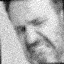

In [ ]:
from PIL import Image, ImageEnhance
import numpy as np
import math

def apply_granulation(image, db):
    # Converte o dB em uma escala linear
    linear_scale = 10 ** (db / 10.0)

    # Converte a imagem para uma matriz numpy
    img_array = np.array(image)

    # Adiciona ruído à matriz de imagem
    noisy_image = img_array + np.random.normal(0, linear_scale, img_array.shape)

    # Normaliza os valores de intensidade para o intervalo [0, 255]
    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)

    # Converte a matriz de volta para uma imagem PIL
    noisy_image = Image.fromarray(noisy_image)

    return noisy_image

# Carrega a imagem de entrada
input_image = Image.open("/content/training/disgust/1098.jpg")

# Aplica granulação com base em dB
granulation_strength_db = 10  # Ajuste o valor de dB conforme necessário
output_image = apply_granulation(input_image, granulation_strength_db)

output_image

In [ ]:
def apply_transformations_full(image, db):
    # Translação
    dx = random.randint(-max_translation, max_translation)
    dy = random.randint(-max_translation, max_translation)
    image = image.transform(image.size, Image.AFFINE, (1, 0, dx, 0, 1, dy))

    # Rotação
    angle = random.uniform(-max_rotation, max_rotation)
    image = image.rotate(angle)

    # Granulação
    linear_scale = 10 ** (db / 10.0)# Converte o dB em uma escala linear

    img_array = np.array(image)
    image = img_array + np.random.normal(0, linear_scale, img_array.shape)# Adiciona ruído à matriz de imagem
    image = np.clip(image, 0, 255).astype(np.uint8)# Normaliza
    image = Image.fromarray(image)

    return image

def apply_transformations_t(image, db):
    # Translação
    dx = random.randint(-max_translation, max_translation)
    dy = random.randint(-max_translation, max_translation)
    image = image.transform(image.size, Image.AFFINE, (1, 0, dx, 0, 1, dy))

    # Granulação
    linear_scale = 10 ** (db / 10.0)# Converte o dB em uma escala linear

    img_array = np.array(image)
    image = img_array + np.random.normal(0, linear_scale, img_array.shape)# Adiciona ruído à matriz de imagem
    image = np.clip(image, 0, 255).astype(np.uint8)# Normaliza
    image = Image.fromarray(image)

    return image

def apply_transformations_r(image, db):

    # Rotação
    angle = random.uniform(-max_rotation, max_rotation)
    image = image.rotate(angle)

    # Granulação
    linear_scale = 10 ** (db / 10.0)# Converte o dB em uma escala linear

    img_array = np.array(image)
    image = img_array + np.random.normal(0, linear_scale, img_array.shape)# Adiciona ruído à matriz de imagem
    image = np.clip(image, 0, 255).astype(np.uint8)# Normaliza
    image = Image.fromarray(image)

    return image

Dados de treino

In [ ]:
# Parâmetros para as transformações
max_translation = 10  # Máxima translação em pixels
max_rotation = 15  # Máxima rotação em graus
granulation_strength = 10  # Intensidade da granulação (dB)

In [ ]:
from PIL import Image, ImageEnhance
import os
import random

# Caminho para o diretório original do dataset
dataset_dir = "/content/training"

# Caminho para o diretório de saída onde as imagens transformadas serão salvas
output_dir = "/content/dataset/train"

# Lista de classes de expressões faciais
expression_classes = os.listdir(dataset_dir)

# Iterar sobre as imagens do dataset, aplicar as transformações e salvar as imagens transformadas
for expression in expression_classes:
    expression_path = os.path.join(dataset_dir, expression)
    output_expression_path = os.path.join(output_dir, expression)

    if not os.path.exists(output_expression_path):
        os.makedirs(output_expression_path)

    image_files = os.listdir(expression_path)

    for image_file in image_files:
        image_path = os.path.join(expression_path, image_file)
        img = Image.open(image_path)

        # Aplicar transformações
        transformed_img_full = apply_transformations_full(img, granulation_strength)
        transformed_img_t = apply_transformations_t(img, granulation_strength)
        transformed_img_r = apply_transformations_r(img, granulation_strength)

        output_image_path_full = os.path.join(output_expression_path, f"tr_{image_file}")
        output_image_path_t = os.path.join(output_expression_path, f"t_{image_file}")
        output_image_path_r = os.path.join(output_expression_path, f"r_{image_file}")

        # Salvar a imagem transformada
        #output_image_path = os.path.join(output_expression_path, image_file)
        transformed_img_full.save(output_image_path_full)
        transformed_img_t.save(output_image_path_t)
        transformed_img_r.save(output_image_path_r)

In [ ]:
# Diretório principal onde estão as subpastas
pasta_train = "/content/dataset/train"  # Substitua pelo caminho correto para sua pasta "train"

# Lista das subpastas dentro de "train"
subpastas = os.listdir(pasta_train)

# Loop para contar o número de arquivos em cada subpasta
for subpasta in subpastas:
    subpasta_path = os.path.join(pasta_train, subpasta)
    if os.path.isdir(subpasta_path):
        num_arquivos = len(os.listdir(subpasta_path))
        print(f"A pasta '{subpasta}' contém {num_arquivos} arquivos.")


A pasta 'neutral' contém 756 arquivos.
A pasta 'sadness' contém 972 arquivos.
A pasta 'happy' contém 960 arquivos.
A pasta 'fear' contém 804 arquivos.
A pasta 'surprise' contém 873 arquivos.
A pasta 'disgust' contém 630 arquivos.
A pasta 'anger' contém 945 arquivos.


Dados de teste

In [ ]:
# Caminho para o diretório original do dataset
dataset_dir = "/content/testing"

# Caminho para o diretório de saída onde as imagens transformadas serão salvas
output_dir = "/content/dataset/test"

# Lista de classes de expressões faciais
expression_classes = os.listdir(dataset_dir)

# Iterar sobre as imagens do dataset, aplicar as transformações e salvar as imagens transformadas
for expression in expression_classes:
    expression_path = os.path.join(dataset_dir, expression)
    output_expression_path = os.path.join(output_dir, expression)

    if not os.path.exists(output_expression_path):
        os.makedirs(output_expression_path)

    image_files = os.listdir(expression_path)

    for image_file in image_files:
        image_path = os.path.join(expression_path, image_file)
        img = Image.open(image_path)

        # Aplicar transformações
        transformed_img_full = apply_transformations_full(img, granulation_strength)
        transformed_img_t = apply_transformations_t(img, granulation_strength)
        transformed_img_r = apply_transformations_r(img, granulation_strength)

        output_image_path_full = os.path.join(output_expression_path, f"tr_{image_file}")
        output_image_path_t = os.path.join(output_expression_path, f"t_{image_file}")
        output_image_path_r = os.path.join(output_expression_path, f"r_{image_file}")

        # Salvar a imagem transformada
        output_image_path = os.path.join(output_expression_path, image_file)
        transformed_img_full.save(output_image_path_full)
        transformed_img_t.save(output_image_path_t)
        transformed_img_r.save(output_image_path_r)

In [ ]:
# Diretório principal onde estão as subpastas
pasta_train = "/content/dataset/test"  # Substitua pelo caminho correto para sua pasta "train"

# Lista das subpastas dentro de "train"
subpastas = os.listdir(pasta_train)

# Loop para contar o número de arquivos em cada subpasta
for subpasta in subpastas:
    subpasta_path = os.path.join(pasta_train, subpasta)
    if os.path.isdir(subpasta_path):
        num_arquivos = len(os.listdir(subpasta_path))
        print(f"A pasta '{subpasta}' contém {num_arquivos} arquivos.")

A pasta 'neutral' contém 93 arquivos.
A pasta 'sadness' contém 120 arquivos.
A pasta 'happy' contém 120 arquivos.
A pasta 'fear' contém 99 arquivos.
A pasta 'surprise' contém 108 arquivos.
A pasta 'disgust' contém 78 arquivos.
A pasta 'anger' contém 117 arquivos.


Dados de Validação

In [ ]:
# Caminho para o diretório original do dataset
dataset_dir = "/content/validation"

# Caminho para o diretório de saída onde as imagens transformadas serão salvas
output_dir = "/content/dataset/val"

# Lista de classes de expressões faciais
expression_classes = os.listdir(dataset_dir)

# Iterar sobre as imagens do dataset, aplicar as transformações e salvar as imagens transformadas
for expression in expression_classes:
    expression_path = os.path.join(dataset_dir, expression)
    output_expression_path = os.path.join(output_dir, expression)

    if not os.path.exists(output_expression_path):
        os.makedirs(output_expression_path)

    image_files = os.listdir(expression_path)

    for image_file in image_files:
        image_path = os.path.join(expression_path, image_file)
        img = Image.open(image_path)

        # Aplicar transformações
        transformed_img_full = apply_transformations_full(img, granulation_strength)
        transformed_img_t = apply_transformations_t(img, granulation_strength)
        transformed_img_r = apply_transformations_r(img, granulation_strength)

        output_image_path_full = os.path.join(output_expression_path, f"tr_{image_file}")
        output_image_path_t = os.path.join(output_expression_path, f"t_{image_file}")
        output_image_path_r = os.path.join(output_expression_path, f"r_{image_file}")

        # Salvar a imagem transformada
        output_image_path = os.path.join(output_expression_path, image_file)
        transformed_img_full.save(output_image_path_full)
        transformed_img_t.save(output_image_path_t)
        transformed_img_r.save(output_image_path_r)

In [ ]:
# Diretório principal onde estão as subpastas
pasta_train = "/content/dataset/val"  # Substitua pelo caminho correto para sua pasta "train"

# Lista das subpastas dentro de "train"
subpastas = os.listdir(pasta_train)

# Loop para contar o número de arquivos em cada subpasta
for subpasta in subpastas:
    subpasta_path = os.path.join(pasta_train, subpasta)
    if os.path.isdir(subpasta_path):
        num_arquivos = len(os.listdir(subpasta_path))
        print(f"A pasta '{subpasta}' contém {num_arquivos} arquivos.")

A pasta 'neutral' contém 96 arquivos.
A pasta 'sadness' contém 126 arquivos.
A pasta 'happy' contém 120 arquivos.
A pasta 'fear' contém 105 arquivos.
A pasta 'surprise' contém 111 arquivos.
A pasta 'disgust' contém 81 arquivos.
A pasta 'anger' contém 120 arquivos.


## Carregando e Treinando o modelo

In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.5/644.5 kB 6.4 MB/s eta 0:00:00


In [ ]:
import torch
import os
import yaml
from ultralytics import YOLO

In [ ]:
# Defina as configurações de treinamentojnk
config = {
    'task': 'cls',            # Tarefa de classificação
    'train': '/content/fer2013/train', # Caminho para o conjunto de treighjtnamento
    'val': '/content/fer2013/val',     # Caminho para o conjunto de validação
    'test': '/content/fer2013/test',
    'nc': 7,                  # Número de classes (por exemplo, 7 emoções)
    'epochs': 100,
    'names': ["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"],             # Número de épocas de treinamento
}

# Salve as configurações em um arquivo YAMLfgtgr
with open('data.yaml', 'w') as f:
    yaml.dump(config, f)

In [ ]:
# Load a model
model = YOLO('yolov8m-cls.yaml')  # build a new model from YAML7
model = YOLO('yolov8m-cls.pt')  # load a pretrained model (recommended for training)
model = YOLO('yolov8m-cls.yaml').load('yolov8m-cls.pt')  # build from YAML and transfer weights


                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   2655744  ultralytics.nn.modules.conv.Conv             [384

In [ ]:
results = model.train(data="/content/dataset/", epochs=150, imgsz=64, batch=32, dropout=0.2)

Ultralytics YOLOv8.0.200 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=classify, mode=train, model=yolov8m-cls.yaml, data=/content/dataset/, epochs=150, patience=50, batch=32, imgsz=64, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.2, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optim

In [ ]:
model.export()

Ultralytics YOLOv8.0.192 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU (Intel Xeon 2.30GHz)
YOLOv8n-cls summary (fused): 73 layers, 1443847 parameters, 0 gradients, 3.3 GFLOPs

PyTorch: starting from 'runs/classify/train4/weights/best.pt' with input shape (1, 3, 64, 64) BCHW and output shape(s) (1, 7) (2.8 MB)

TorchScript: starting export with torch 2.0.1+cu118...
TorchScript: export success ✅ 0.6s, saved as 'runs/classify/train4/weights/best.torchscript' (5.7 MB)

Export complete (1.9s)
Results saved to /content/fer2013/runs/classify/train4/weights
Predict:         yolo predict task=classify model=runs/classify/train4/weights/best.torchscript imgsz=64  
Validate:        yolo val task=classify model=runs/classify/train4/weights/best.torchscript imgsz=64 data=/content/fer2013/  
Visualize:       https://netron.app


'runs/classify/train4/weights/best.torchscript'

## Validando


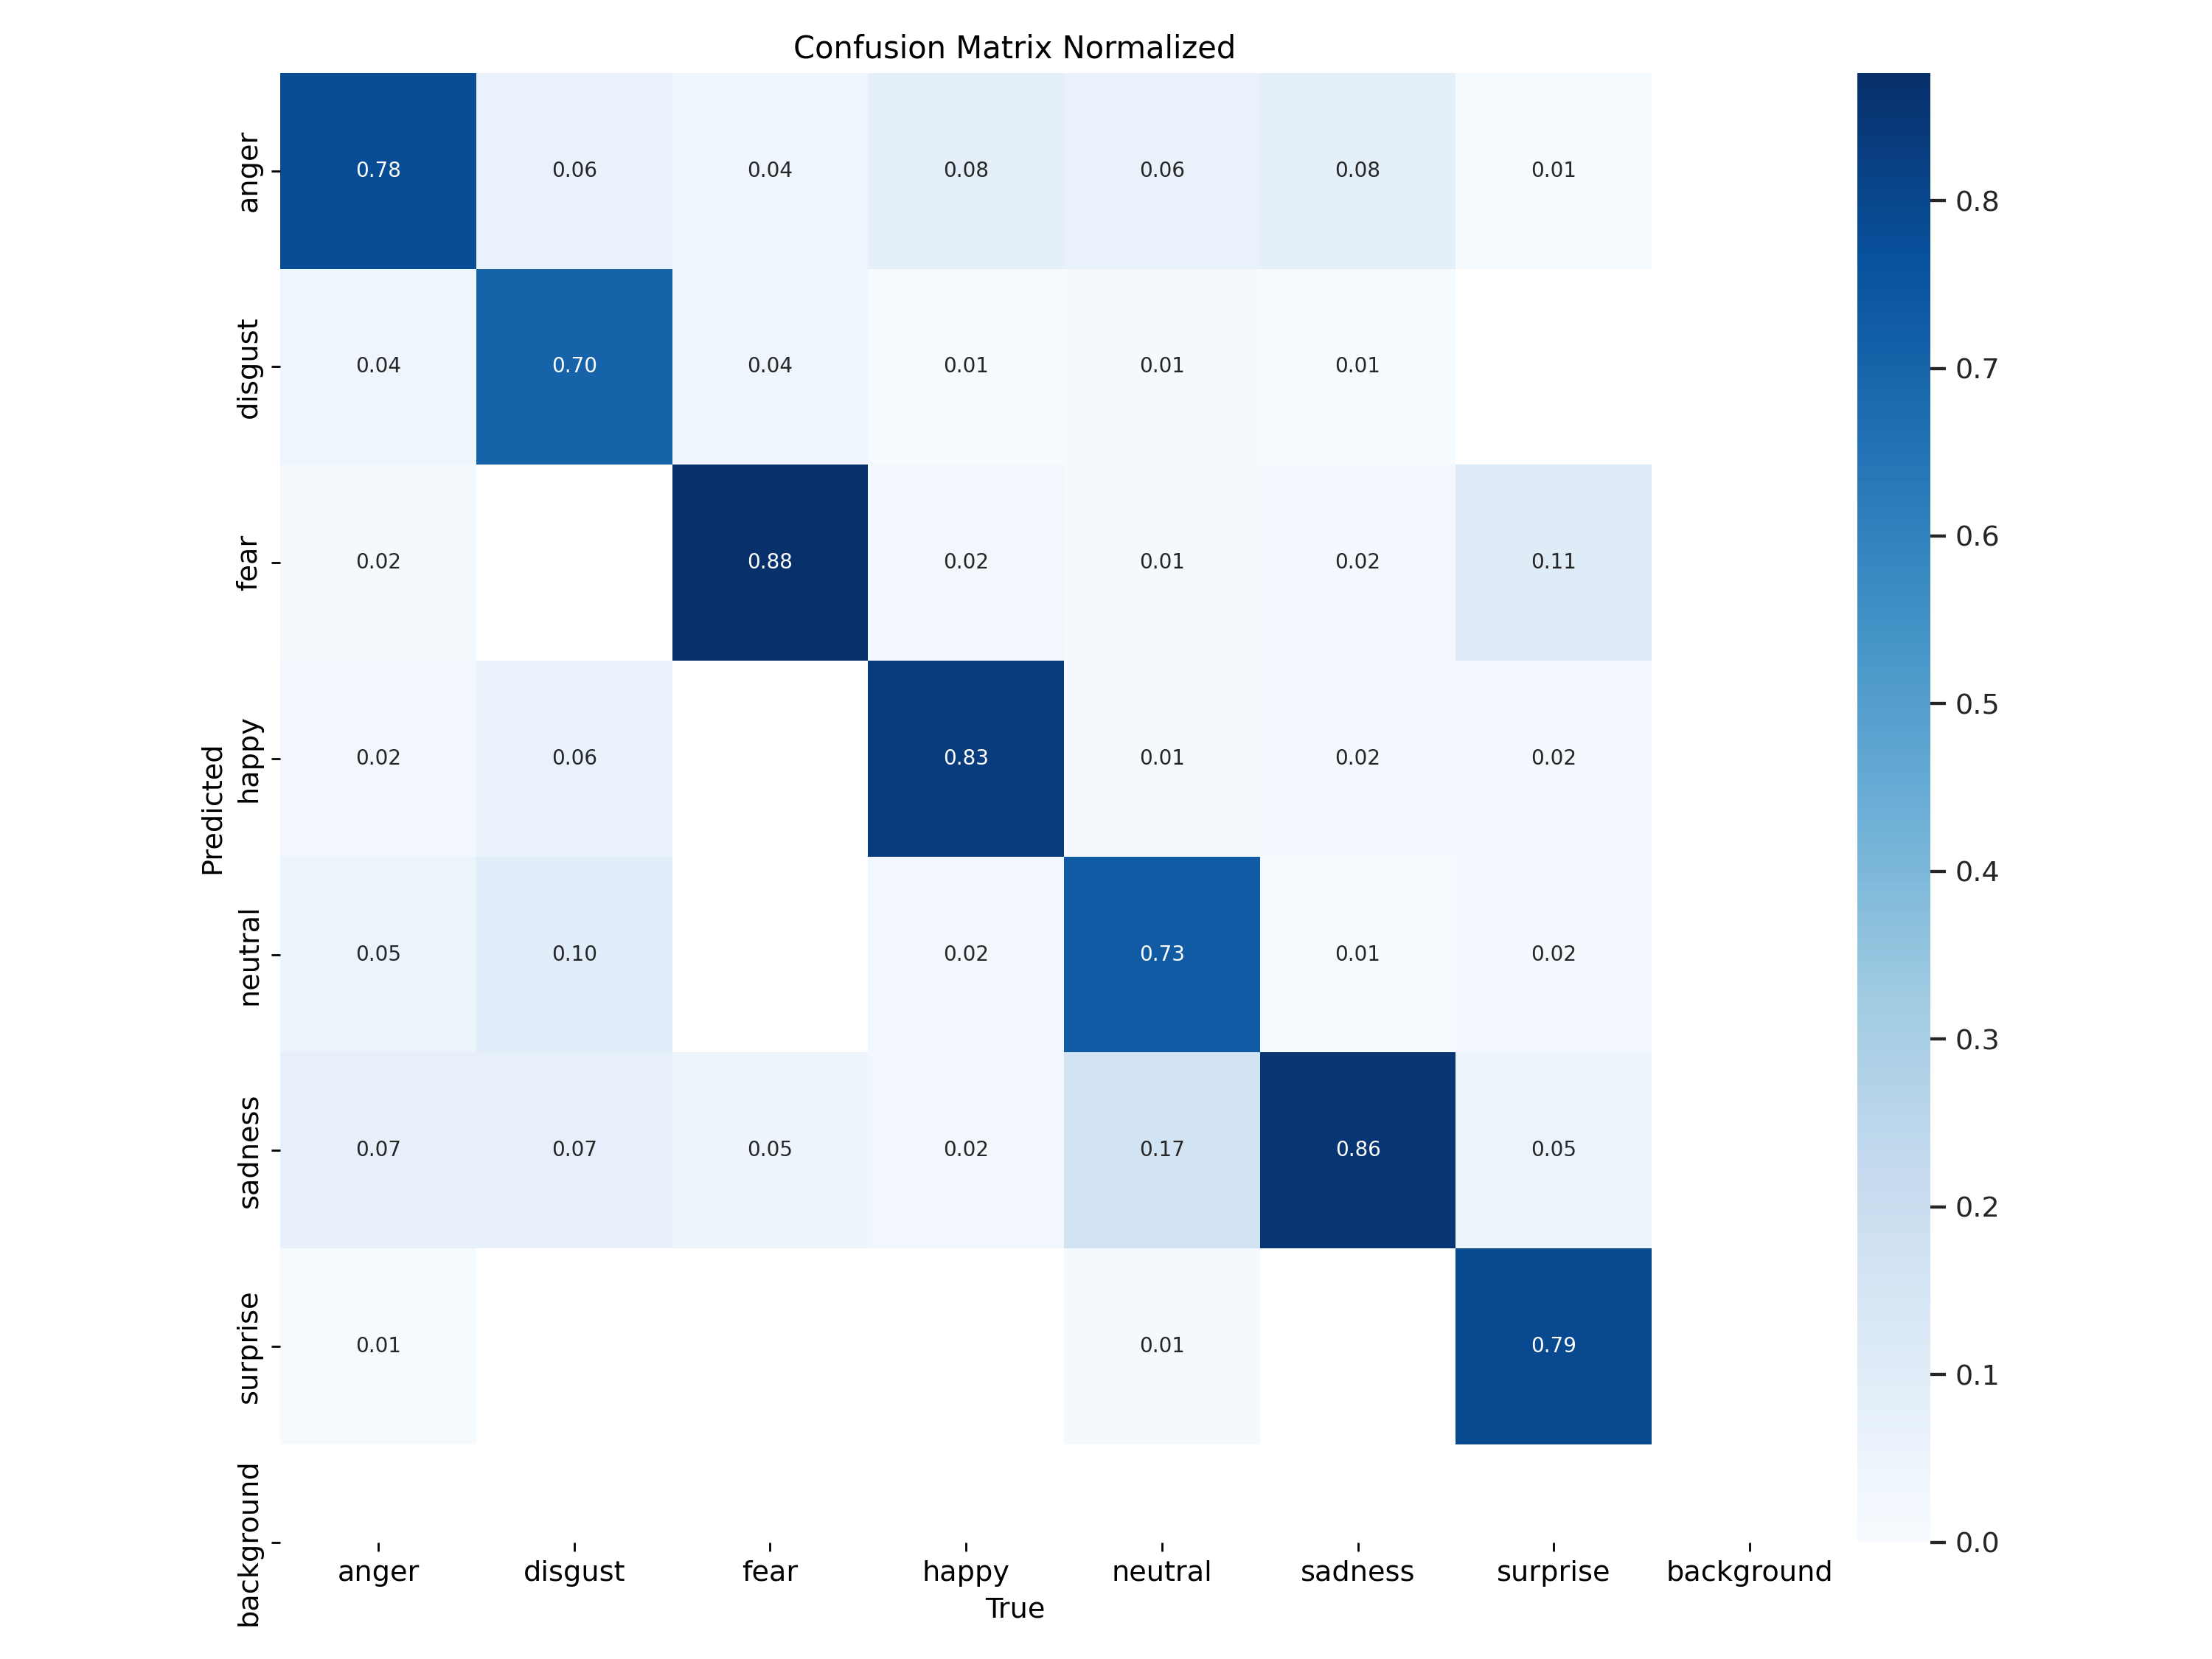

In [ ]:
from IPython.display import Image, display

caminho_imagem = "/content/dataset/runs/classify/train/confusion_matrix_normalized.png"
display(Image(filename=caminho_imagem))

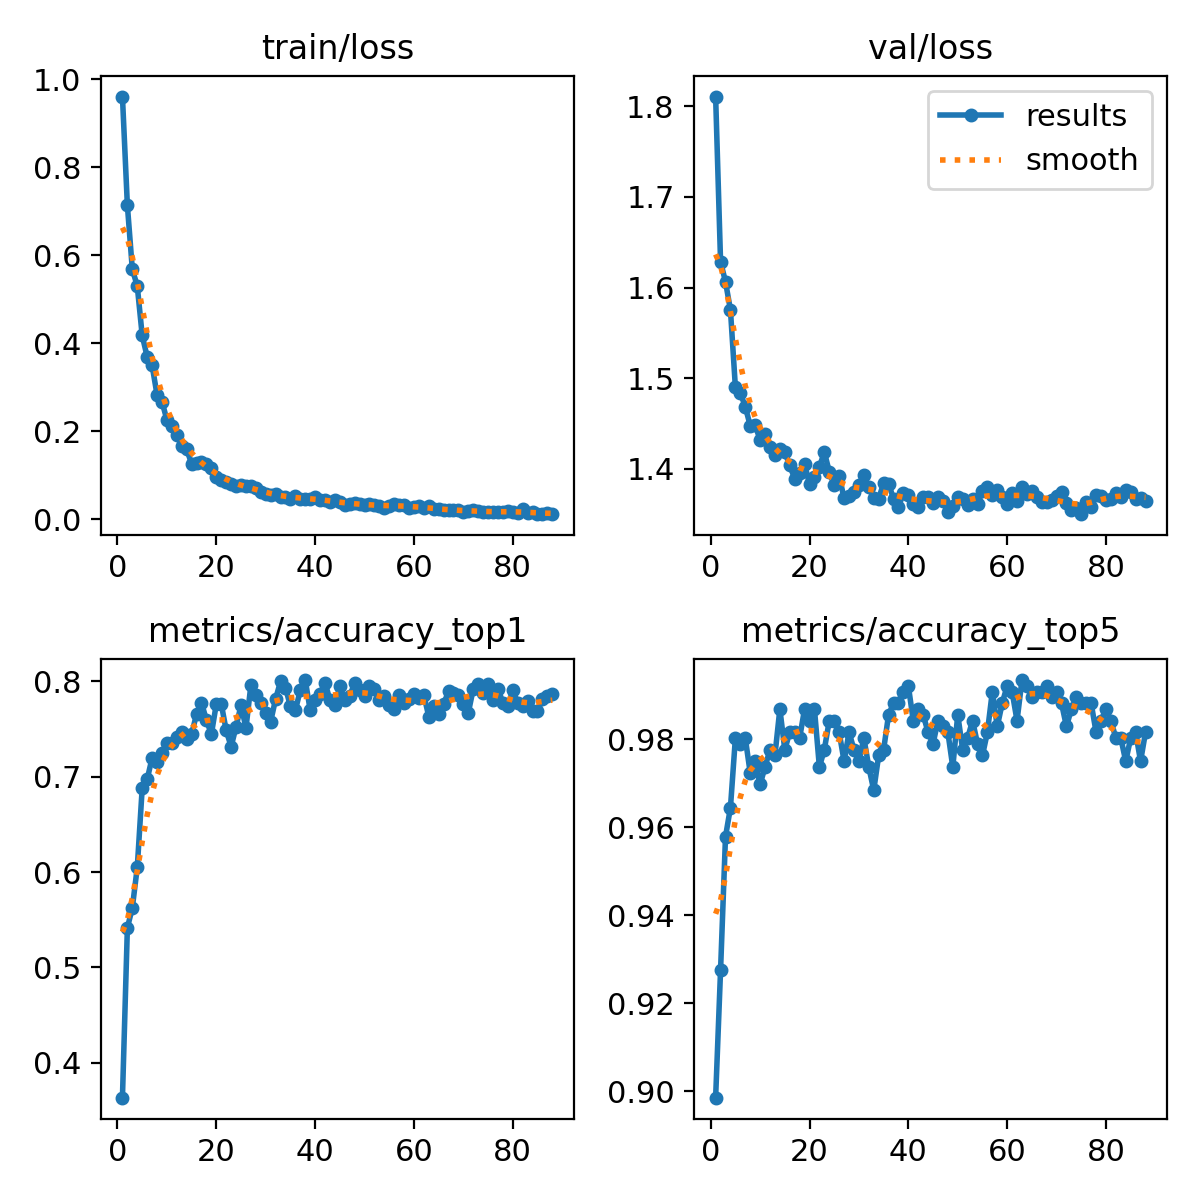

In [ ]:
caminho_imagem = "/content/dataset/runs/classify/train/results.png"
display(Image(filename=caminho_imagem))

## Resultados

In [ ]:
from ultralytics import YOLO

# Load a model
model = YOLO('/content/dataset/runs/classify/train/weights/best.pt')  # pretrained YOLOv8n model

# Run batched inference on a list of images
results = model(['/content/dataset/test/disgust/r_16386.jpg', '/content/dataset/test/surprise/r_S046_002_00000005.png'])  # return a list of Results objects

# Process results list
for result in results:
    boxes = result.boxes  # Boxes object for bbox outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Probs object for classification outputs


0: 64x64 disgust 0.80, sadness 0.18, anger 0.02, happy 0.01, fear 0.00, 1: 64x64 surprise 1.00, anger 0.00, fear 0.00, sadness 0.00, happy 0.00, 55.5ms
Speed: 0.5ms preprocess, 27.8ms inference, 0.1ms postprocess per image at shape (1, 3, 64, 64)


In [ ]:
from PIL import Image
# Run inference on 'bus.jpg'
results = model('/content/dataset/test/disgust/r_16386.jpg')  # results list

# Show the results
for r in results:
    im_array = r.plot()  # plot a BGR numpy array of predictions
    im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
    im.show()  # show image
    im.save('results.jpg')  # save image


image 1/1 /content/dataset/test/disgust/r_16386.jpg: 64x64 disgust 0.80, sadness 0.18, anger 0.02, happy 0.01, fear 0.00, 5.9ms
Speed: 0.5ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 64)


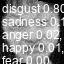

In [ ]:
from IPython.display import Image, display

caminho_imagem = "/content/dataset/results.jpg"
display(Image(filename=caminho_imagem))